In [97]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers, regularizers

In [3]:
patients_df = pd.read_csv('patients.csv')

In [4]:
patients_df.head(20)

,subject_id,hadm_id,stay_id,los,gender,avg_weight,avg_height,death_status,age_at_admission,died_within_30_days,died_within_90_days,died_within_1_year,days_in_icu,charlson_comorbidity_index
0,10000980,26913865,39765666,0.497535,F,76.200000,NaN,Deceased,76,False,False,False,6,9
1,10002013,23581541,39060235,1.314352,F,100.050000,157.0,Alive,57,NaN,NaN,NaN,5,8
2,10002443,21329021,35044219,2.750729,M,154.850000,178.0,Alive,53,NaN,NaN,NaN,3,4
3,10002495,24982426,36753294,5.087512,M,64.175000,170.0,Alive,81,NaN,NaN,NaN,7,7
4,10005817,20626031,32604416,2.359097,M,93.050000,173.0,Deceased,66,False,False,False,8,8
5,10005817,28661809,31316840,15.972812,M,88.185714,175.0,Deceased,69,True,True,True,16,8
6,10006580,24159665,38329661,0.898449,F,77.900000,147.0,Alive,63,NaN,NaN,NaN,5,4
7,10007795,28477357,31921355,1.050521,F,79.950000,NaN,Alive,53,NaN,NaN,NaN,22,3
8,10007818,22987108,32359580,20.528681,M,99.371429,185.0,Deceased,69,True,True,True,32,9
9,10009628,25926192,35258379,2.280752,M,71.100000,168.0,Alive,58,NaN,NaN,NaN,8,4


In [5]:
patient_stats = patients_df.drop(columns=['death_status','died_within_30_days','died_within_90_days','died_within_1_year','days_in_icu'])

In [6]:
patient_stats = patients_df.drop(columns=['died_within_30_days','died_within_90_days','died_within_1_year','days_in_icu'])

In [7]:
# patient_mortality_30 = patients_df.drop(columns=['died_within_30_days','died_within_90_days','died_within_1_year','days_in_icu'])

In [8]:
patient_stats.head(1)

,subject_id,hadm_id,stay_id,los,gender,avg_weight,avg_height,death_status,age_at_admission,charlson_comorbidity_index
0,10000980,26913865,39765666,0.497535,F,76.2,NaN,Deceased,76,9


In [9]:
vitals_df = pd.read_csv('vitals.csv')

In [13]:
result = vitals_df.groupby(['subject_id', 'hadm_id', 'stay_id']).first().reset_index()

In [70]:
merged_df = result.merge(patient_stats, on=['subject_id', 'hadm_id', 'stay_id'], how='inner')
merged_df = merged_df.drop(columns=['temperature_site'])
merged_df = pd.get_dummies(merged_df, columns=['gender'], prefix='gender')

In [68]:
merged_df.head(1)

,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,...,temperature_site,spo2,glucose,los,avg_weight,avg_height,age_at_admission,charlson_comorbidity_index,gender_F,gender_M
0,10000980,26913865,39765666,2189-06-27 08:54:00,77.0,150.0,77.0,92.0,150.0,77.0,...,NaN,100.0,110.0,0.497535,76.2,NaN,76,9,True,False


In [71]:
merged_df.shape

(15422, 22)

In [72]:
print(np.mean(merged_df['los']))

3.517653037147509


# Model


In [73]:

# Load your dataframe
# df = pd.read_csv('your_data_file.csv')

# Drop non-feature columns
X = merged_df.drop(columns=['subject_id', 'hadm_id', 'stay_id','charttime','los']) 
y = merged_df['los']

# Handle missing values (simple imputation)
X.fillna(X.mean(), inplace=True)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [137]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers, regularizers

model = Sequential([
    Dense(256, activation='relu',kernel_regularizer=regularizers.l1(0.01), input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    Dropout(0.2),
    Dense(128,kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    layers.BatchNormalization(),
    Dense(128, activation='relu'),
    layers.BatchNormalization(),
    Dense(64, activation='relu'),
    layers.BatchNormalization(),
    Dense(32, activation='relu'),
    layers.BatchNormalization(),
    Dense(1, activation='sigmoid')  # Linear activation for regression
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [138]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/200
174/174 [==============================] - 2s 4ms/step - loss: 10.2818 - accuracy: 0.7482 - val_loss: 2.3583 - val_accuracy: 0.8566
Epoch 2/200
174/174 [==============================] - 1s 4ms/step - loss: 1.4504 - accuracy: 0.8404 - val_loss: 0.9676 - val_accuracy: 0.8566
Epoch 3/200
174/174 [==============================] - 1s 4ms/step - loss: 0.7866 - accuracy: 0.8482 - val_loss: 0.7046 - val_accuracy: 0.8566
Epoch 4/200
174/174 [==============================] - 1s 4ms/step - loss: 0.6248 - accuracy: 0.8511 - val_loss: 0.5818 - val_accuracy: 0.8549
Epoch 5/200
174/174 [==============================] - 1s 4ms/step - loss: 0.5479 - accuracy: 0.8536 - val_loss: 0.4939 - val_accuracy: 0.8614
Epoch 6/200
174/174 [==============================] - 1s 4ms/step - loss: 0.5000 - accuracy: 0.8518 - val_loss: 0.4796 - val_accuracy: 0.8590
Epoch 7/200
174/174 [==============================] - 1s 4ms/step - loss: 0.4849 - accuracy: 0.8525 - val_loss: 0.4583 - val_accuracy: 0.856

In [146]:
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.18).astype(int)
print(classification_report(y_test, binary_predictions))


97/97 [==============================] - 0s 961us/step
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      2655
           1       0.36      0.67      0.47       430

    accuracy                           0.79      3085
   macro avg       0.65      0.74      0.67      3085
weighted avg       0.86      0.79      0.81      3085



In [113]:


# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
print("Linear Regression MAE:", mean_absolute_error(y_test, lr_predictions))

# 2. Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
print("Decision Tree MAE:", mean_absolute_error(y_test, dt_predictions))

# 3. Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest MAE:", mean_absolute_error(y_test, rf_predictions))

# 4. XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost MAE:", mean_absolute_error(y_test, xgb_predictions))

# 5. SVR
svr_model = SVR(kernel='linear')
svr_model.fit(X_train, y_train)
svr_predictions = svr_model.predict(X_test)
print("SVR MAE:", mean_absolute_error(y_test, svr_predictions))


Linear Regression MAE: 0.2239778744784306
Decision Tree MAE: 0.19254457050243112


KeyboardInterrupt: 

# Mortality


In [61]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)





In [14]:
mortality_df = result.merge(patients_df, on=['subject_id', 'hadm_id', 'stay_id'], how='inner')
mortality_df = mortality_df.drop(columns=['temperature_site'])
mortality_df = pd.get_dummies(mortality_df, columns=['gender'], prefix='gender')

In [15]:
mortality_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'charttime', 'heart_rate', 'sbp',
       'dbp', 'mbp', 'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature',
       'spo2', 'glucose', 'los', 'avg_weight', 'avg_height', 'death_status',
       'age_at_admission', 'died_within_30_days', 'died_within_90_days',
       'died_within_1_year', 'days_in_icu', 'charlson_comorbidity_index',
       'gender_F', 'gender_M'],
      dtype='object')

In [24]:
mortality_df['died_within_30_days'] = mortality_df['died_within_30_days'].fillna(value = False)
mortality_df['died_within_90_days'] = mortality_df['died_within_90_days'].fillna(value = False)
mortality_df['died_within_1_year'] = mortality_df['died_within_1_year'].fillna(value = False)

In [62]:
# Drop non-feature columns
X = mortality_df.drop(columns=['subject_id', 'hadm_id', 'stay_id','death_status','charttime','died_within_30_days', 'died_within_90_days',
       'died_within_1_year']) 
y = mortality_df['died_within_30_days'].astype(int)

# Handle missing values (simple imputation)
X.fillna(X.mean(), inplace=True)
X_30_smote, y_30_smote = smote.fit_resample(X, y)
# Normalize the features
scaler = StandardScaler()
X_30_smote = scaler.fit_transform(X_30_smote)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_30_smote, y_30_smote, test_size=0.2, random_state=42)


In [63]:
# Drop non-feature columns
X_90 = mortality_df.drop(columns=['subject_id', 'hadm_id', 'stay_id','death_status','charttime','died_within_30_days', 'died_within_90_days',
       'died_within_1_year']) 
y_90 = mortality_df['died_within_90_days'].astype(int)

# Handle missing values (simple imputation)
X_90.fillna(X_90.mean(), inplace=True)
X_90_smote, y_90_smote = smote.fit_resample(X_90, y_90)
# Normalize the features
scaler_90 = StandardScaler()
X_90_smote = scaler_90.fit_transform(X_90_smote)

# Split the dataset
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90_smote, y_90_smote, test_size=0.2, random_state=42)


In [82]:
# Drop non-feature columns
X_year = mortality_df.drop(columns=['subject_id', 'hadm_id', 'stay_id','death_status','charttime','died_within_30_days', 'died_within_90_days',
       'died_within_1_year']) 
y_year = mortality_df['died_within_1_year'].astype(int)

# Handle missing values (simple imputation)
X_year.fillna(X_year.mean(), inplace=True)
X_year_smote, y_year_smote = smote.fit_resample(X_year, y_year)
# Normalize the features
scaler_year = StandardScaler()
X_year_smote = scaler_year.fit_transform(X_year_smote)

# Split the dataset
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(X_year_smote, y_year_smote, test_size=0.2, random_state=42)


In [117]:
mortality_df.to_csv('mortality.csv')

In [98]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu',kernel_regularizer=regularizers.l1(0.01), input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    Dropout(0.2),
    Dense(128,kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    layers.BatchNormalization(),
    Dense(128, activation='relu'),
    layers.BatchNormalization(),
    Dense(64, activation='relu'),
    layers.BatchNormalization(),
    Dense(32, activation='relu'),
    layers.BatchNormalization(),
    Dense(1, activation='sigmoid')  # Linear activation for regression
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [99]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
528/528 [==============================] - 3s 4ms/step - loss: 6.2574 - accuracy: 0.7363 - val_loss: 1.2904 - val_accuracy: 0.7244
Epoch 2/50
528/528 [==============================] - 2s 4ms/step - loss: 0.8685 - accuracy: 0.7477 - val_loss: 0.6626 - val_accuracy: 0.7645
Epoch 3/50
528/528 [==============================] - 2s 4ms/step - loss: 0.6582 - accuracy: 0.7479 - val_loss: 0.6090 - val_accuracy: 0.7645
Epoch 4/50
528/528 [==============================] - 2s 4ms/step - loss: 0.6206 - accuracy: 0.7562 - val_loss: 0.5906 - val_accuracy: 0.7592
Epoch 5/50
528/528 [==============================] - 2s 4ms/step - loss: 0.6105 - accuracy: 0.7501 - val_loss: 0.5817 - val_accuracy: 0.7704
Epoch 6/50
528/528 [==============================] - 2s 4ms/step - loss: 0.5893 - accuracy: 0.7584 - val_loss: 0.5430 - val_accuracy: 0.7704
Epoch 7/50
528/528 [==============================] - 2s 4ms/step - loss: 0.5710 - accuracy: 0.7543 - val_loss: 0.5432 - val_accuracy: 0.7626
Epoch 

In [89]:
predictions1 = model.predict(X_test)
binary_predictions1 = (predictions1 > 0.5).astype(int)
print(classification_report(y_test, binary_predictions1))

165/165 [==============================] - 0s 695us/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      2664
           1       0.86      0.77      0.81      2610

    accuracy                           0.82      5274
   macro avg       0.83      0.82      0.82      5274
weighted avg       0.83      0.82      0.82      5274



In [75]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

165/165 [==============================] - 0s 1ms/step - loss: 0.3720 - accuracy: 0.8221
Test Accuracy: 82.21%


In [76]:
model_90 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_90.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_90.fit(X_train_90, y_train_90, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
501/501 [==============================] - 1s 2ms/step - loss: 0.5981 - accuracy: 0.6855 - val_loss: 0.4949 - val_accuracy: 0.7527
Epoch 2/50
501/501 [==============================] - 1s 2ms/step - loss: 0.5021 - accuracy: 0.7495 - val_loss: 0.4574 - val_accuracy: 0.7650
Epoch 3/50
501/501 [==============================] - 1s 2ms/step - loss: 0.4805 - accuracy: 0.7559 - val_loss: 0.4497 - val_accuracy: 0.7717
Epoch 4/50
501/501 [==============================] - 1s 2ms/step - loss: 0.4686 - accuracy: 0.7656 - val_loss: 0.4485 - val_accuracy: 0.7755
Epoch 5/50
501/501 [==============================] - 1s 2ms/step - loss: 0.4622 - accuracy: 0.7709 - val_loss: 0.4420 - val_accuracy: 0.7767
Epoch 6/50
501/501 [==============================] - 1s 2ms/step - loss: 0.4549 - accuracy: 0.7710 - val_loss: 0.4435 - val_accuracy: 0.7785
Epoch 7/50
501/501 [==============================] - 1s 2ms/step - loss: 0.4551 - accuracy: 0.7725 - val_loss: 0.4455 - val_accuracy: 0.7765
Epoch 

In [90]:
predictions2 = model_90.predict(X_test_90)
binary_predictions2 = (predictions2 > 0.5).astype(int)
print(classification_report(y_test_90, binary_predictions2))

157/157 [==============================] - 0s 759us/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2497
           1       0.81      0.78      0.79      2507

    accuracy                           0.80      5004
   macro avg       0.80      0.80      0.80      5004
weighted avg       0.80      0.80      0.80      5004



In [80]:
loss, accuracy = model.evaluate(X_test_90, y_test_90)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

157/157 [==============================] - 0s 1ms/step - loss: 0.4121 - accuracy: 0.7888
Test Accuracy: 78.88%


In [83]:
model_year = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_year.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_year.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_year.fit(X_train_year, y_train_year, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
442/442 [==============================] - 1s 2ms/step - loss: 0.6322 - accuracy: 0.6417 - val_loss: 0.5312 - val_accuracy: 0.7286
Epoch 2/50
442/442 [==============================] - 1s 2ms/step - loss: 0.5563 - accuracy: 0.7201 - val_loss: 0.5026 - val_accuracy: 0.7425
Epoch 3/50
442/442 [==============================] - 1s 2ms/step - loss: 0.5272 - accuracy: 0.7272 - val_loss: 0.4940 - val_accuracy: 0.7433
Epoch 4/50
442/442 [==============================] - 1s 2ms/step - loss: 0.5209 - accuracy: 0.7382 - val_loss: 0.4933 - val_accuracy: 0.7470
Epoch 5/50
442/442 [==============================] - 1s 2ms/step - loss: 0.5147 - accuracy: 0.7420 - val_loss: 0.4888 - val_accuracy: 0.7433
Epoch 6/50
442/442 [==============================] - 1s 2ms/step - loss: 0.5086 - accuracy: 0.7426 - val_loss: 0.4911 - val_accuracy: 0.7465
Epoch 7/50
442/442 [==============================] - 1s 2ms/step - loss: 0.5048 - accuracy: 0.7468 - val_loss: 0.4901 - val_accuracy: 0.7419
Epoch 

In [91]:
predictions3 = model_year.predict(X_test_year)
binary_predictions3 = (predictions3 > 0.5).astype(int)
print(classification_report(y_test_year, binary_predictions3))

138/138 [==============================] - 0s 756us/step
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      2231
           1       0.79      0.74      0.77      2181

    accuracy                           0.78      4412
   macro avg       0.78      0.78      0.78      4412
weighted avg       0.78      0.78      0.78      4412



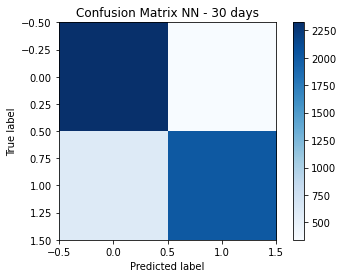

In [88]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Your data

y_pred = binary_predictions  # Predicted labels

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix NN - 30 days')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

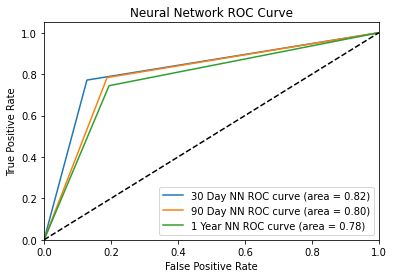

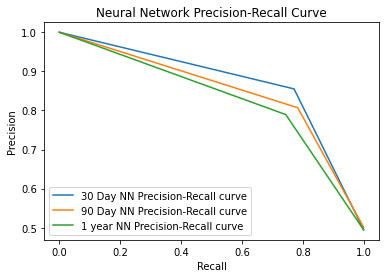

In [95]:
# Your data

y_pred1 = binary_predictions1  # Predicted labels from Model 1
y_pred2 = binary_predictions2 # Predicted labels from Model 2
y_pred3 = binary_predictions3 # Predicted labels from Model 3

# ROC Curve for multiple models
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_90, y_pred2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test_year, y_pred3)
roc_auc3 = auc(fpr3, tpr3)

plt.figure()
plt.plot(fpr1, tpr1, label=f'30 Day NN ROC curve (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'90 Day NN ROC curve (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'1 Year NN ROC curve (area = {roc_auc3:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve for multiple models
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test_90, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test_year, y_pred3)

plt.figure()
plt.plot(recall1, precision1, label='30 Day NN Precision-Recall curve')
plt.plot(recall2, precision2, label='90 Day NN Precision-Recall curve')
plt.plot(recall3, precision3, label='1 year NN Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Neural Network Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()